In [2]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torchvision
import ssl

import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision.transforms as transforms

seed = 1234
np.random.seed(seed)

# Required to prevent urlopen error where certificate has expired
ssl._create_default_https_context = ssl._create_unverified_context

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

# Assuming that we are on a CUDA machine, this should print a CUDA device:

print(device)

/home/zechen/miniconda3/envs/cs178/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


cpu


In [7]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.6, 0.6, 0.6), (0.2, 0.2, 0.2), (0.2, 0.2, 0.2))])

batch_size = 256

gen = torch.Generator()
gen.manual_seed(seed)

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=2, generator=gen)

valset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
valloader = torch.utils.data.DataLoader(valset, batch_size=batch_size,
                                         shuffle=False, num_workers=2, generator=gen)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=2, generator=gen)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

print(len(trainset), len(valset), len(testset))

Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Dataset CIFAR10
    Number of datapoints: 10000
    Root location: ./data
    Split: Test
    StandardTransform
Transform: Compose(
               ToTensor()
               Normalize(mean=(0.6, 0.6, 0.6), std=(0.2, 0.2, 0.2))
           )
Dataset CIFAR10
    Number of datapoints: 10000
    Root location: ./data
    Split: Test
    StandardTransform
Transform: Compose(
               ToTensor()
               Normalize(mean=(0.6, 0.6, 0.6), std=(0.2, 0.2, 0.2))
           )


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


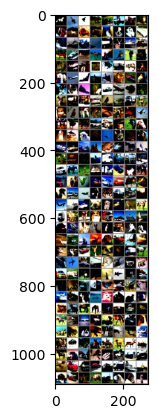

horse plane plane horse cat   truck truck bird  horse horse frog  dog   cat   dog   dog   truck deer  ship  car   plane truck deer  ship  horse horse ship  plane horse truck bird  bird  bird  frog  car   dog   deer  dog   truck cat   truck dog   plane plane horse plane dog   plane bird  cat   cat   plane deer  car   plane frog  frog  deer  horse cat   ship  bird  truck truck dog   dog   bird  dog   frog  dog   horse truck plane horse bird  horse car   truck truck bird  horse dog   cat   dog   deer  plane cat   frog  bird  ship  car   ship  horse frog  car   horse ship  deer  plane horse bird  truck truck horse deer  car   horse deer  ship  truck car   cat   horse car   bird  frog  truck car   truck horse frog  bird  plane plane horse cat   truck truck truck plane ship  ship  dog   dog   car   bird  horse truck cat   deer  dog   truck plane ship  ship  dog   plane cat   deer  cat   cat   cat   horse deer  plane ship  deer  frog  car   deer  ship  cat   bird  car   deer  bird  frog  truc

In [3]:
# functions to show an image

# transpose image RGB channels so it can be viewed in color
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

# get some random training images
dataiter = iter(trainloader)
images, labels = next(dataiter)

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join(f'{classes[labels[j]]:5s}' for j in range(batch_size)))

In [4]:
class AlexNet(nn.Module):

    def __init__(self, num_classes):
        super(AlexNet, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=11, padding=2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
            
            nn.Conv2d(64, 192, kernel_size=5, padding=2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
            
            nn.Conv2d(192, 384, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            
            nn.Conv2d(384, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
        )
        self.avgpool = nn.AdaptiveAvgPool2d((6, 6))
        self.classifier = nn.Sequential(
            nn.Dropout(0.5),
            nn.Linear(256 * 6 * 6, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(0.5),
            nn.Linear(4096, 4096),
            nn.ReLU(inplace=True),
            nn.Linear(4096, num_classes)
        )

    def forward(self, x):
        x = self.features(x)
        x = self.avgpool(x)
        x = x.view(x.size(0), 256 * 6 * 6)
        logits = self.classifier(x)
        probas = F.softmax(logits, dim=1)
        return logits
    
# single hidden layer convolutional neural network
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 6, 5) # input 3 channel images, output 6 channel images, kernel size 5x5
        self.pool = nn.MaxPool2d(2, 2) # 2x2 pooling
        self.conv2 = nn.Conv2d(6, 16, 5)
        
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x


net = AlexNet(10)
print(net)

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(1, 1), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

In [5]:
net.to(device)

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(1, 1), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

In [6]:
torch.manual_seed(seed)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(net.parameters(), lr=0.0001)  
#optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

In [ ]:
for epoch in range(40):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        #inputs, labels = data
        inputs, labels = data[0].to(device), data[1].to(device)
        
        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 50 == 49:    # print every 50 mini-batches
            print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / 50:.3f}')
            running_loss = 0.0

print('Finished Training')

[1,    50] loss: 2.068
[1,   100] loss: 1.818
[1,   150] loss: 1.656
[2,    50] loss: 1.453
[2,   100] loss: 1.382
[2,   150] loss: 1.345
[3,    50] loss: 1.218
[3,   100] loss: 1.182
[3,   150] loss: 1.152
[4,    50] loss: 1.046
[4,   100] loss: 1.020
[4,   150] loss: 1.028


In [ ]:
dataiter = iter(valloader)
nextData = next(dataiter)
images, labels = nextData[0].to(device), nextData[1].to(device)

# print images

print([classes[labels[j]] for j in range(4)])

# convert to using CPU instead of GPU since it's not compatible for imshow
normalImages, normalLabels = images.to(torch.device('cpu')), labels.to(torch.device('cpu'))

imshow(torchvision.utils.make_grid(normalImages))
print('GroundTruth: ', ' '.join(f'{classes[normalLabels[j]]:5s}' for j in range(4)))


In [ ]:
outputs = net(images)

# ignore first value
_, predicted = torch.max(outputs, 1)

print('Predicted: ', ' '.join(f'{classes[predicted[j]]:5s}'
                              for j in range(4)))

In [ ]:
correct = 0
total = 0
# since we're not training, we don't need to calculate the gradients for our outputs
with torch.no_grad():
    for data in valloader:
        images, labels = data[0].to(device), data[1].to(device)
        # calculate outputs by running images through the network
        outputs = net(images)
        # the class with the highest energy is what we choose as prediction
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Accuracy of the network on the 10000 test images: {100 * correct // total} %')

In [ ]:
# prepare to count predictions for each class
correct_pred = {classname: 0 for classname in classes}
total_pred = {classname: 0 for classname in classes}

# again no gradients needed
with torch.no_grad():
    for data in testloader:
        images, labels = data[0].to(device), data[1].to(device)
        outputs = net(images)
        _, predictions = torch.max(outputs, 1)
        # collect the correct predictions for each class
        for label, prediction in zip(labels, predictions):
            if label == prediction:
                correct_pred[classes[label]] += 1
            total_pred[classes[label]] += 1


# print accuracy for each class
for classname, correct_count in correct_pred.items():
    accuracy = 100 * float(correct_count) / total_pred[classname]
    print(f'Accuracy for class: {classname:5s} is {accuracy:.1f} %')

For 30 output channel images (60 output on the second conv2d):

Accuracy of the network on the 10000 test images: 61 %

Accuracy for class: plane is 46.2 %

Accuracy for class: car   is 83.4 %

Accuracy for class: bird  is 45.7 %

Accuracy for class: cat   is 33.0 %

Accuracy for class: deer  is 50.1 %

Accuracy for class: dog   is 50.5 %

Accuracy for class: frog  is 83.6 %

Accuracy for class: horse is 67.7 %

Accuracy for class: ship  is 90.2 %

Accuracy for class: truck is 61.7 %

For 1050 output channel images (2150 output on the second conv2d):

Accuracy of the network on the 10000 test images: 66 %
    
Accuracy for class: plane is 79.3 %
    
Accuracy for class: car   is 83.3 %
    
Accuracy for class: bird  is 35.5 %
    
Accuracy for class: cat   is 52.8 %
    
Accuracy for class: deer  is 46.5 %
    
Accuracy for class: dog   is 45.6 %
    
Accuracy for class: frog  is 88.1 %
    
Accuracy for class: horse is 75.4 %
    
Accuracy for class: ship  is 81.9 %
    
Accuracy for class: truck is 76.8 %

[1,  2000] loss: 1.884
    
[1,  4000] loss: 1.577
    
[1,  6000] loss: 1.419
    
[1,  8000] loss: 1.320
    
[1, 10000] loss: 1.255
    
[1, 12000] loss: 1.200
    
[2,  2000] loss: 1.078
    
[2,  4000] loss: 1.035
    
[2,  6000] loss: 1.041
    
[2,  8000] loss: 0.995
    
[2, 10000] loss: 0.992
    
[2, 12000] loss: 0.940
    

For 6 output channel images (6 output on second conv2d):

Accuracy of the network on the 10000 test images: 54 %

Accuracy for class: plane is 61.9 %

Accuracy for class: car   is 77.6 %

Accuracy for class: bird  is 31.5 %

Accuracy for class: cat   is 29.3 %

Accuracy for class: deer  is 52.7 %

Accuracy for class: dog   is 47.9 %

Accuracy for class: frog  is 62.6 %

Accuracy for class: horse is 64.2 %

Accuracy for class: ship  is 66.4 %

Accuracy for class: truck is 48.3 %

[1,  2000] loss: 2.042

[1,  4000] loss: 1.713

[1,  6000] loss: 1.625

[1,  8000] loss: 1.558

[1, 10000] loss: 1.496

[1, 12000] loss: 1.472

[2,  2000] loss: 1.396

[2,  4000] loss: 1.396

[2,  6000] loss: 1.355

[2,  8000] loss: 1.348

[2, 10000] loss: 1.341

[2, 12000] loss: 1.316


For 600 output channel images (1200 output on second conv2d):

Accuracy of the network on the 10000 test images: 67 %

Accuracy for class: plane is 71.7 %

Accuracy for class: car   is 75.1 %

Accuracy for class: bird  is 64.1 %

Accuracy for class: cat   is 42.1 %

Accuracy for class: deer  is 67.6 %

Accuracy for class: dog   is 41.8 %

Accuracy for class: frog  is 71.6 %

Accuracy for class: horse is 79.4 %

Accuracy for class: ship  is 84.3 %

Accuracy for class: truck is 80.8 %

[1,  2000] loss: 1.889

[1,  4000] loss: 1.538

[1,  6000] loss: 1.402

[1,  8000] loss: 1.343

[1, 10000] loss: 1.248

[1, 12000] loss: 1.178

[2,  2000] loss: 1.043

[2,  4000] loss: 1.049

[2,  6000] loss: 1.000

[2,  8000] loss: 0.962

[2, 10000] loss: 0.981

[2, 12000] loss: 0.920


For 90 output channel images (180 output on second conv2d):

Accuracy of the network on the 10000 test images: 70 %

Accuracy for class: plane is 61.7 %

Accuracy for class: car   is 79.2 %

Accuracy for class: bird  is 65.8 %

Accuracy for class: cat   is 52.5 %

Accuracy for class: deer  is 63.0 %

Accuracy for class: dog   is 54.8 %

Accuracy for class: frog  is 84.0 %

Accuracy for class: horse is 76.3 %

Accuracy for class: ship  is 85.4 %

Accuracy for class: truck is 85.7 %

[1,  2000] loss: 2.039

[1,  4000] loss: 1.645

[1,  6000] loss: 1.483

[1,  8000] loss: 1.405

[1, 10000] loss: 1.292

[1, 12000] loss: 1.226

[2,  2000] loss: 1.106

[2,  4000] loss: 1.089

[2,  6000] loss: 1.039

[2,  8000] loss: 1.004

[2, 10000] loss: 0.973

[2, 12000] loss: 0.964

[3,  2000] loss: 0.807

[3,  4000] loss: 0.817

[3,  6000] loss: 0.820

[3,  8000] loss: 0.806

[3, 10000] loss: 0.810

[3, 12000] loss: 0.803
